# Section 5.5 — Hierarchical models

This notebook contains the code examples from [Section 5.5 Hierarchical models]() from the **No Bullshit Guide to Statistics**.

See also:
- [03_hierarchical_model.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/03_hierarchical_model.ipynb)
- [cs109b_lect13_bayes_2_2021.ipynb](./explorations/cs109b_lect13_bayes_2_2021.ipynb)
- https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section4-Hierarchical_Models.ipynb
- https://mc-stan.org/users/documentation/case-studies/radon_cmdstanpy_plotnine.html#data-prep
- https://github.com/mitzimorris/brms_feb_28_2023/blob/main/brms_notebook.Rmd
- https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/hierarchical"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

In [4]:
# silence statsmodels kurtosistest warning when using n < 20
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Definitions

## Model

## Radon dataset

https://bambinos.github.io/bambi/notebooks/radon_example.html

- Description: Contains measurements of radon levels in homes across various counties.
- Source: Featured in Andrew Gelman and Jennifer Hill's book Data Analysis Using Regression and Multilevel/Hierarchical Models.
- Application: Demonstrates partial pooling and varying intercepts/slopes in hierarchical modeling.


### Loading the data

In [5]:
radon = pd.read_csv("../datasets/radon.csv")
radon

,idnum,state,county,floor,log_radon,log_uranium
0,5081,MN,AITKIN,ground,0.788457,-0.689048
1,5082,MN,AITKIN,basement,0.788457,-0.689048
2,5083,MN,AITKIN,basement,1.064711,-0.689048
3,5084,MN,AITKIN,basement,0.000000,-0.689048
4,5085,MN,ANOKA,basement,1.131402,-0.847313
...,...,...,...,...,...,...
914,5995,MN,WRIGHT,basement,1.856298,-0.090024
915,5996,MN,WRIGHT,basement,1.504077,-0.090024
916,5997,MN,WRIGHT,basement,1.609438,-0.090024
917,5998,MN,YELLOW MEDICINE,basement,1.308333,0.355287


## Complete pooling model

= common linear regression model for all counties

We can  pool all the data and estimate one big regression to asses the influence of the floor variable
on radon levels across all counties.

$$
  Y = \beta_0 + \beta_x \cdot x.
$$

The variable $x$ corresponds to the `floor` column,
with $0$ representing basement, and $1$ representing ground floor.

By ignoring the county feature, we do not differenciate on counties.

In [6]:
import bambi as bmb

priors1 = {}

mod1 = bmb.Model("log_radon ~ 1 + floor", data=radon)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
mod1

       Formula: log_radon ~ 1 + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.3354)
            floor ~ Normal(mu: 0.0, sigma: 5.7237)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

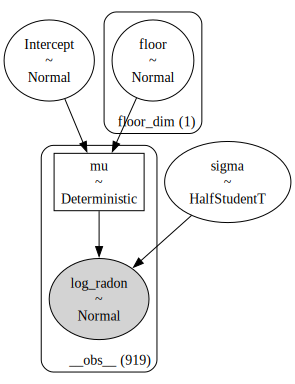

In [8]:
mod1.build()
mod1.graph()

In [9]:
idata1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
import arviz as az

az.summary(idata1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.327,0.031,1.264,1.382,0.000,0.000,6762.0,3301.0,1.0
floor[ground],-0.614,0.072,-0.753,-0.484,0.001,0.001,6420.0,3029.0,1.0
sigma,0.823,0.019,0.787,0.859,0.000,0.000,5432.0,3114.0,1.0


Default computed for conditional variable: floor


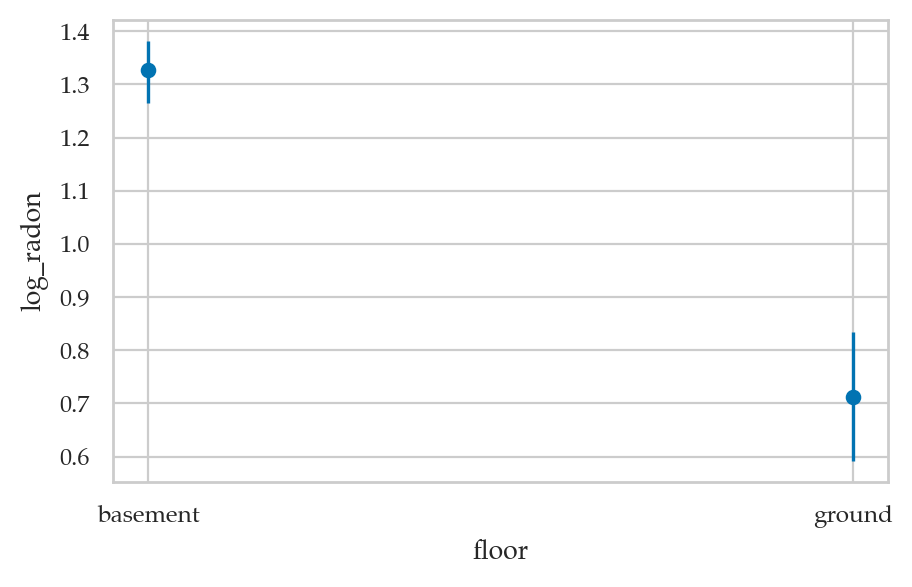

In [11]:
bmb.interpret.plot_predictions(mod1, idata1, "floor");

## No pooling model

= separate intercept for each county 

If we treat different counties as independent,
so each one gets an intercept term:

$$
  Y_j = \beta_{0j} + \beta_{x} x.
$$



In [71]:
priors2 = None
# {
#     "county:floor": bmb.Prior("Normal", mu=0, sigma=10),
#     "sigma": bmb.Prior("Exponential", lam=1),
# }

mod2 = bmb.Model("log_radon ~ 0 + county + floor",
                 priors=priors2,
                 data=radon)
# mod2

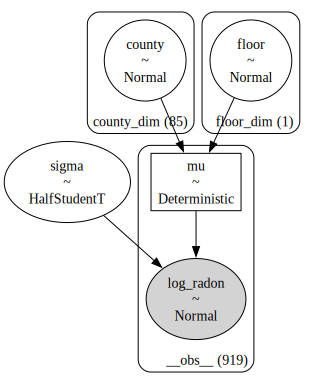

In [72]:
mod2.build()
mod2.graph()

In [73]:
idata2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, county, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


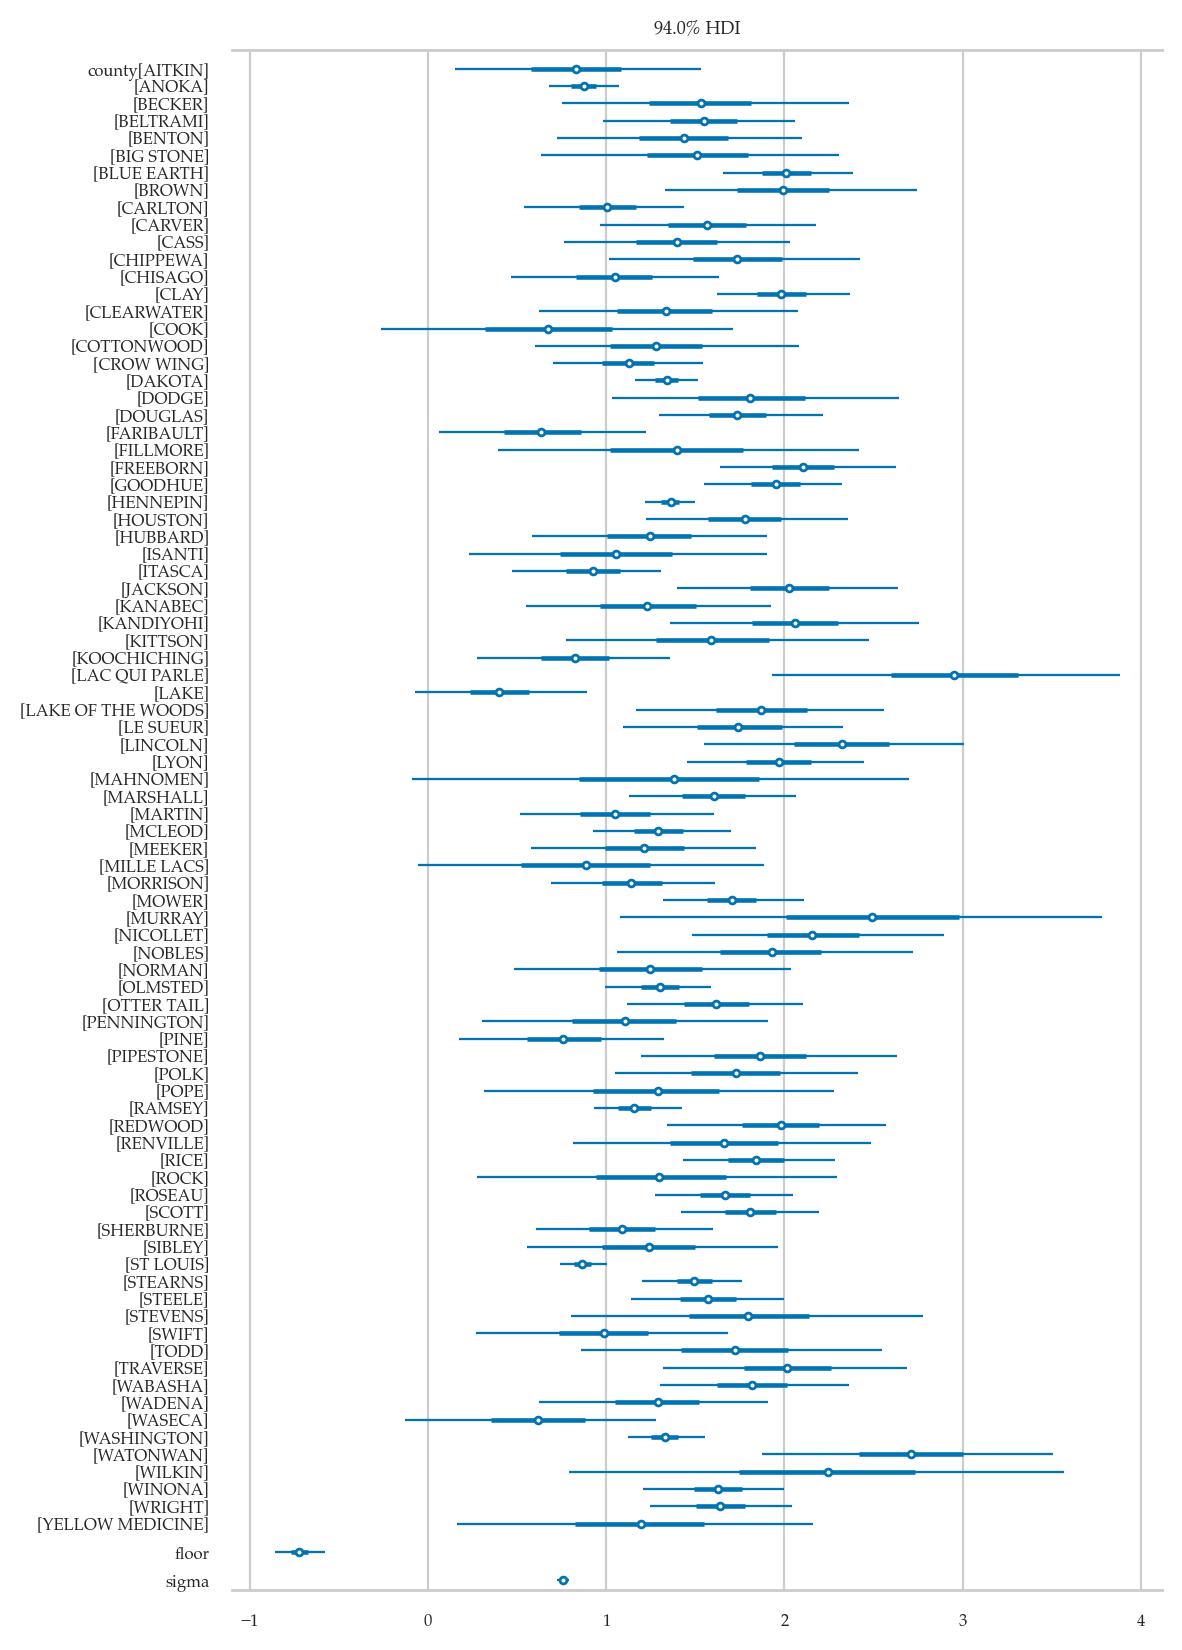

In [79]:
az.plot_forest(data=idata2, figsize=(6, 10), combined=True, textsize=6);

Default computed for conditional variable: floor, county


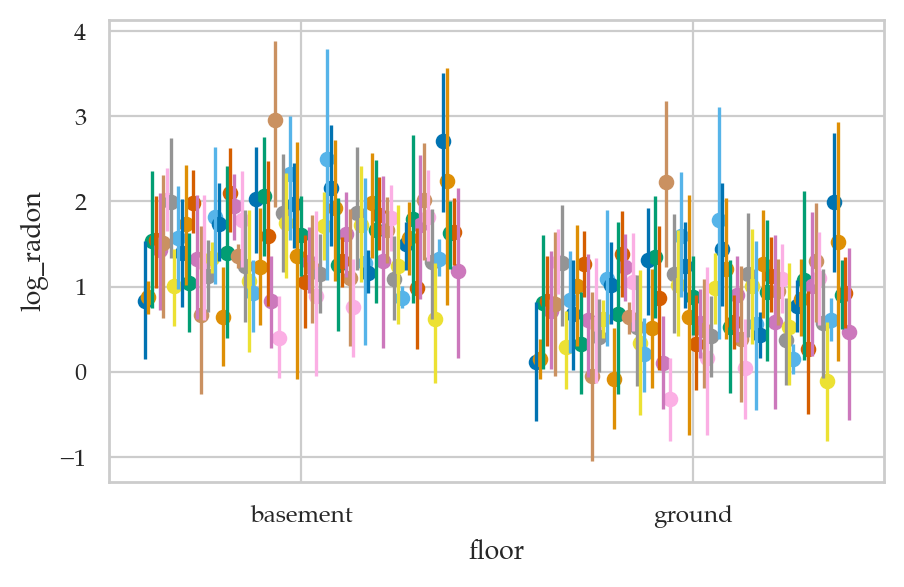

In [80]:
fig, axs = bmb.interpret.plot_predictions(mod2, idata2, ["floor", "county"]);
axs[0].get_legend().remove()

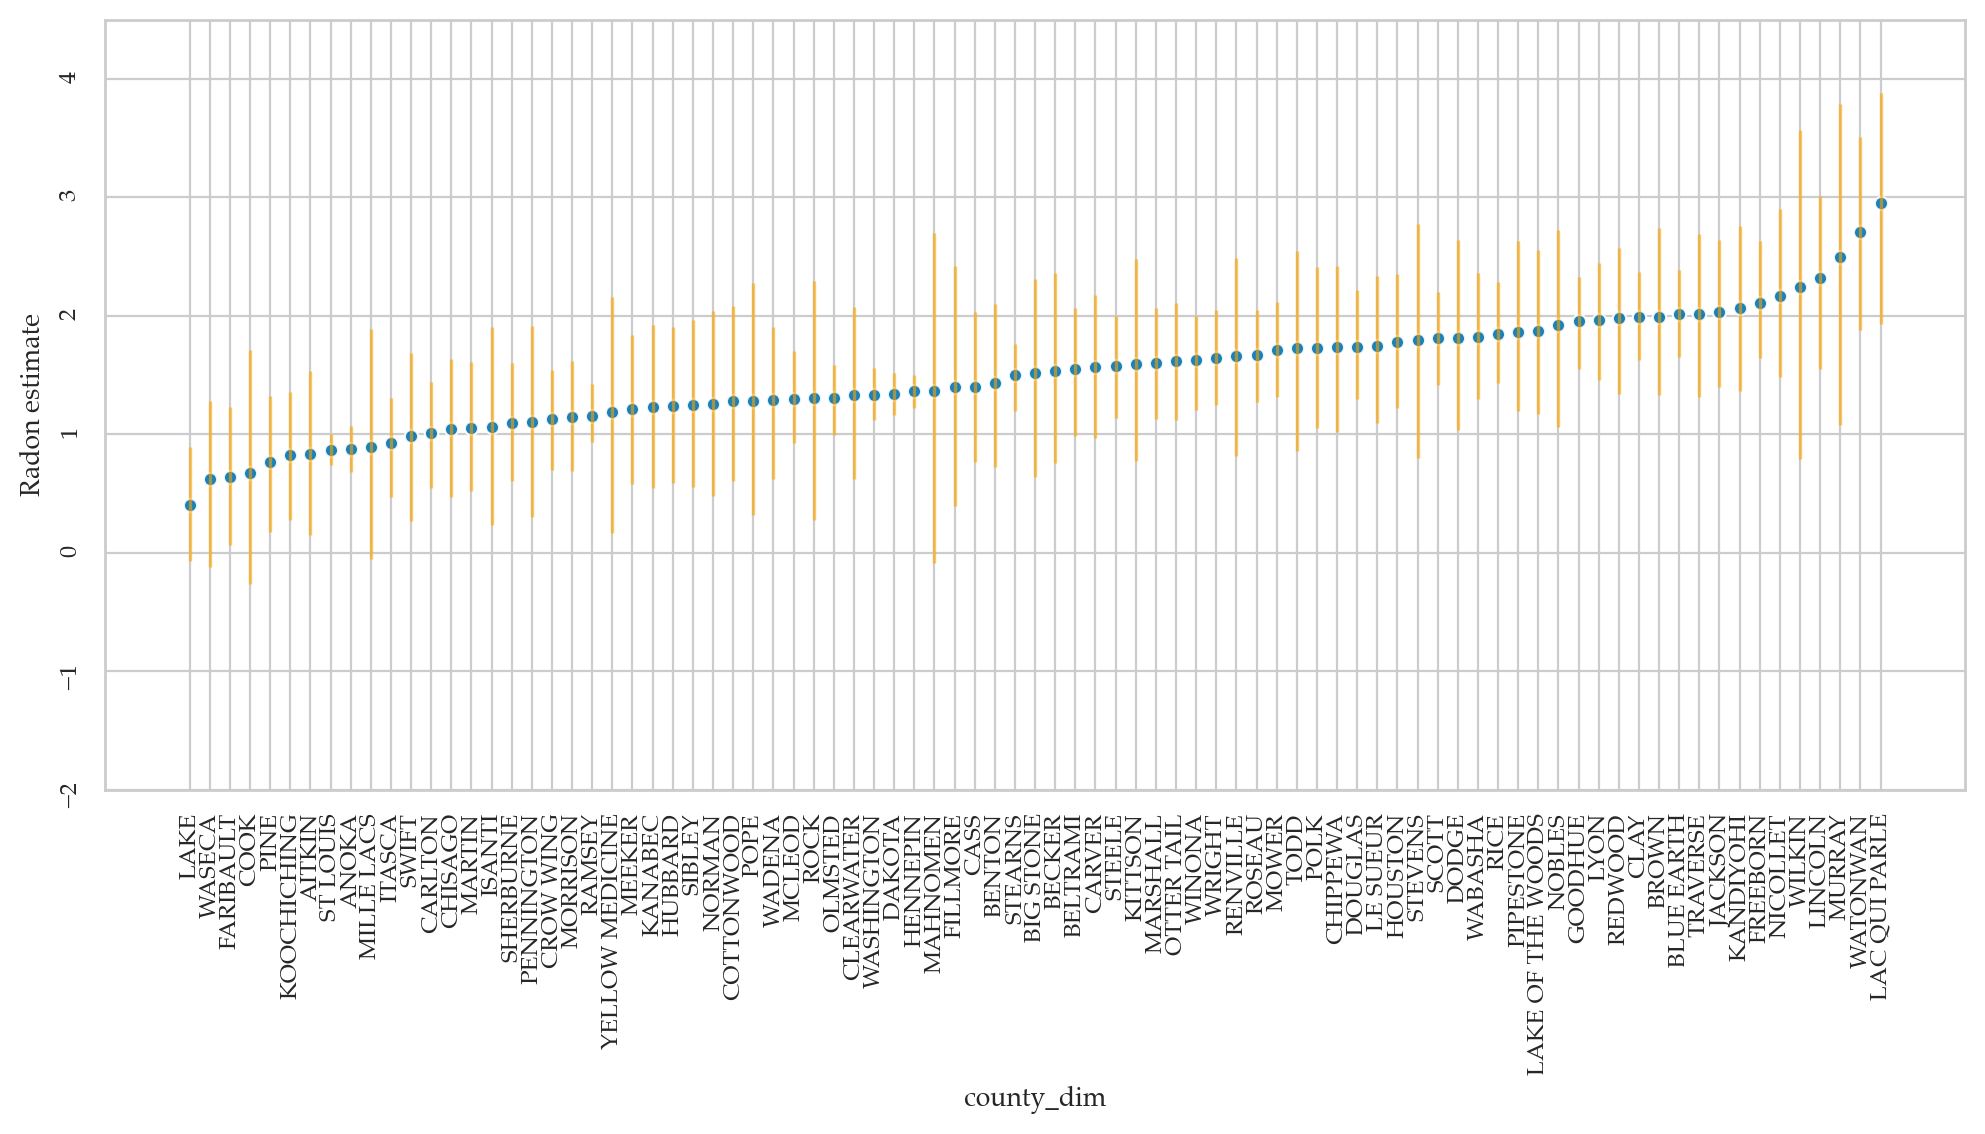

In [81]:
post2 = idata2["posterior"]
unpooled_means = post2.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(idata2)

unpooled_means_iter = unpooled_means.sortby("county")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.county)

_, ax = plt.subplots(figsize=(12, 5))
unpooled_means_iter.plot.scatter(x="county_dim", y="county", ax=ax, alpha=0.9)
ax.vlines(
    np.arange(len(radon["county"].unique())),
    unpooled_hdi_iter.county.sel(hdi="lower"),
    unpooled_hdi_iter.county.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.tick_params(rotation=90);

## Hierarchical model

= partial pooling model
= varying intercepts model

\begin{align*}
Y_j      \;\; &\sim \;\; \mathcal{N}(B_0 + B_j + B_x x, \, \Sigma_Y),  \\
B_0      \;\; &\sim \;\; \mathcal{N}(\mu_{B_0},\sigma_{B_0}), \\
B_x      \;\; &\sim \;\; \mathcal{N}(\mu_{B_J},\sigma_{B_x}), \\
B_j      \;\; &\sim \;\; \mathcal{N}(0,\Sigma_{B_j}), \\
\Sigma_Y \;\; &\sim \;\;  \mathcal{T}^+(\nu=4, \sigma=?), \\
\Sigma_B \;\; &\sim \;\;  \mathcal{T}^+(\nu=4, \sigma=?).
\end{align*}


The partial pooling formula estimates per-county intercepts which drawn
from the same distribution which is estimated jointly with the rest of
the model parameters. The `1` is the intercept co-efficient. The
estimates across counties will all have the same slope.


    log_radon ~ 1 + (1|county_id) + floor


There is a middle ground to both of these extremes.
Specifically, we may assume that the intercepts are different for each county as in the unpooled case,
but they are drawn from the same distribution.
The different counties are effectively sharing information through the common prior.


NOTE: some counties have very few sample; the hierarchical model will provide "shrinkage" for these groups, and use global information learned from all counties


### Bayesian model
TODO: add formulas

### Bambi model

In [17]:
priors3 = {
    # "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
    # "sigma": bmb.Prior("HalfNormal", sigma=10), # from PyStan tutorial
    # "sigma": bmb.Prior("Uniform", lower=0, upper=100), # from PyMC example
}

mod3 = bmb.Model(formula="log_radon ~ 1 + (1|county) + floor",
                 priors=priors3,
                 data=radon,
                 noncentered=False)

mod3

       Formula: log_radon ~ 1 + (1|county) + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.1322)
            floor ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

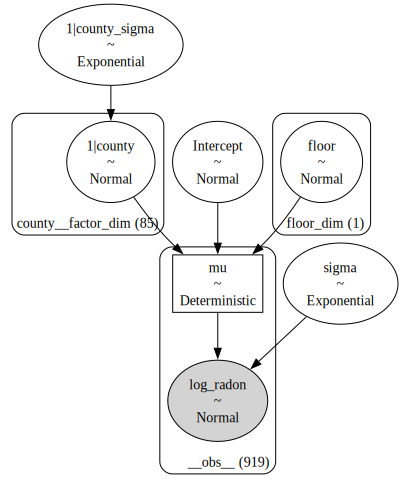

In [18]:
mod3.build()
mod3.graph()

### Model fitting and analysis

In [19]:
idata3 = mod3.fit(draws=2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor, 1|county_sigma, 1|county]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


The group level parameters

In [20]:
az.summary(idata3).head(5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[AITKIN],-0.274,0.256,-0.756,0.204,0.002,0.002,16791.0,6249.0,1.0
1|county[ANOKA],-0.533,0.113,-0.741,-0.316,0.001,0.001,9300.0,6256.0,1.0
1|county[BECKER],0.016,0.262,-0.481,0.498,0.002,0.003,20111.0,6123.0,1.0
1|county[BELTRAMI],0.042,0.220,-0.369,0.451,0.002,0.003,18127.0,5709.0,1.0
1|county[BENTON],-0.017,0.257,-0.494,0.476,0.002,0.003,21740.0,5497.0,1.0


In [21]:
az.summary(idata3).tail(5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[YELLOW MEDICINE],-0.079,0.286,-0.619,0.452,0.002,0.004,20392.0,5708.0,1.0
1|county_sigma,0.334,0.046,0.251,0.425,0.001,0.001,2927.0,3685.0,1.0
Intercept,1.462,0.053,1.358,1.555,0.001,0.001,4534.0,5950.0,1.0
floor[ground],-0.692,0.070,-0.827,-0.564,0.001,0.000,16337.0,6082.0,1.0
sigma,0.757,0.019,0.724,0.794,0.000,0.000,17034.0,6008.0,1.0


The intercept offsets for each county are:

In [22]:
sum( idata3["posterior"]["1|county"].stack(sample=("chain","draw")).values.mean(axis=1) )

-0.011758113563528294

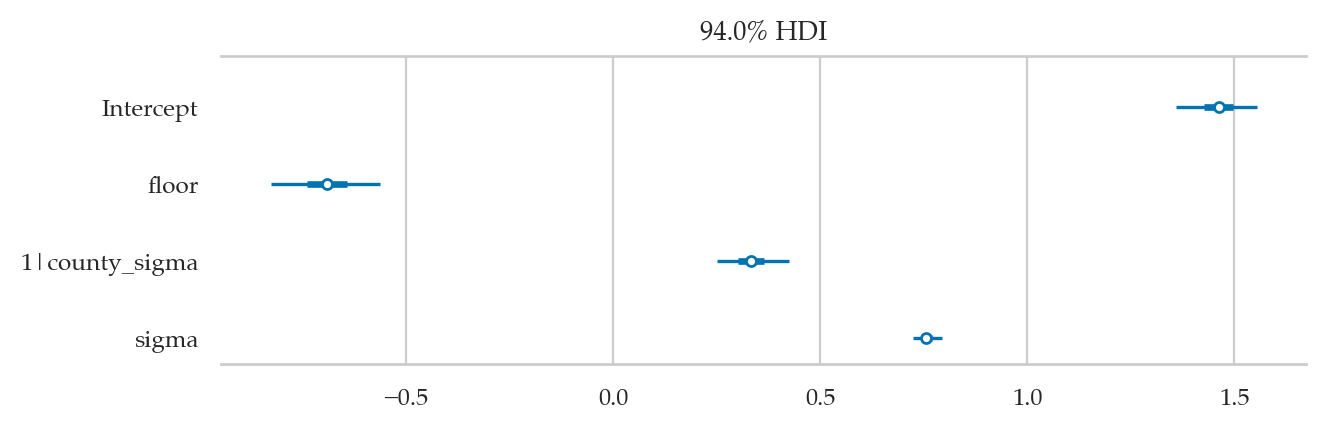

In [23]:
az.plot_forest(idata3, combined=True, figsize=(7,2),
               var_names=["Intercept", "floor", "1|county_sigma", "sigma"]);

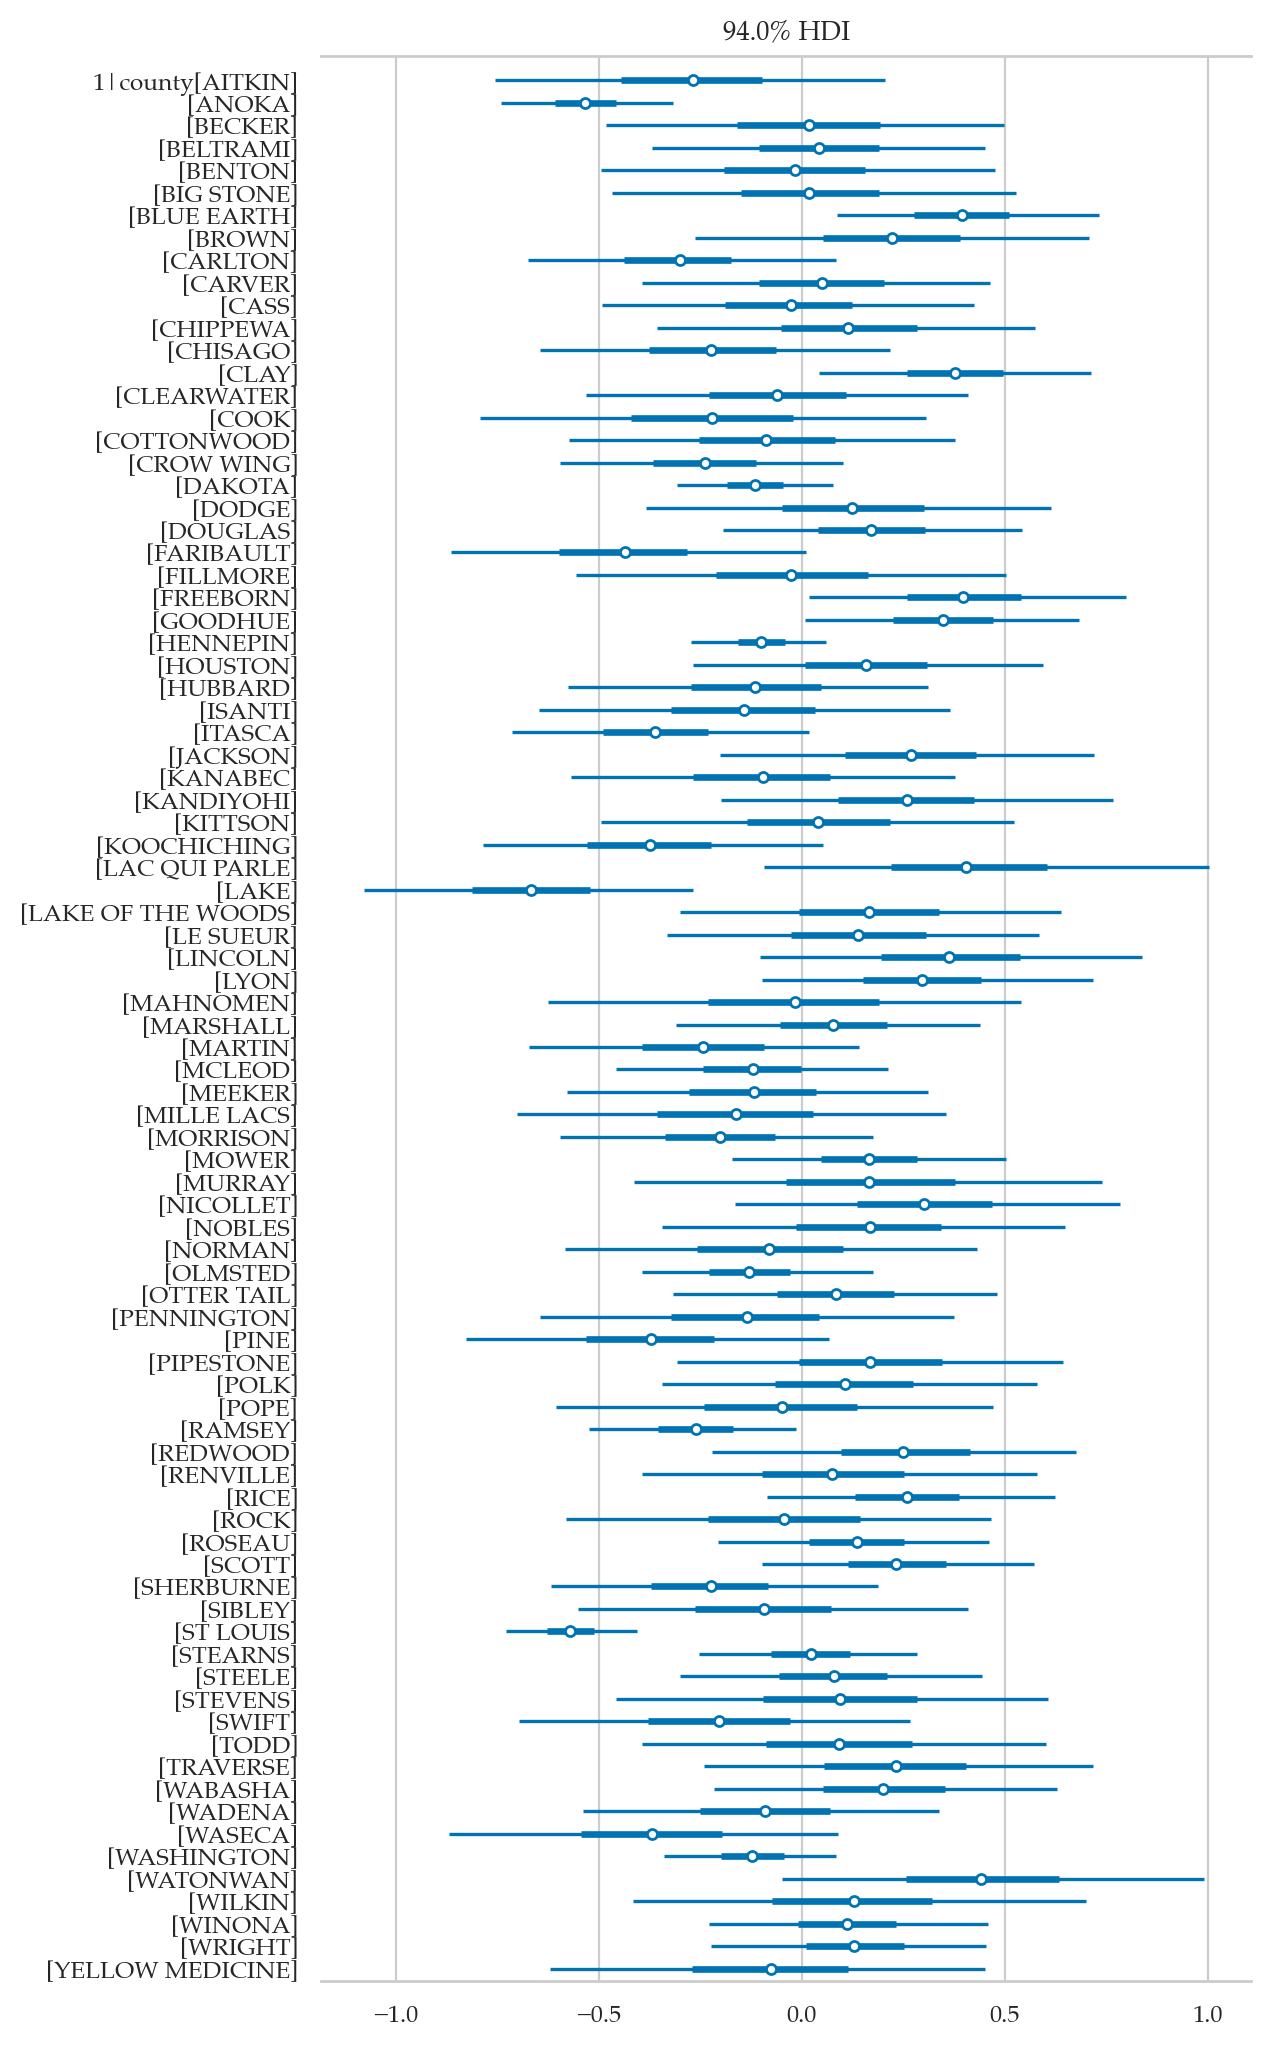

In [24]:
az.plot_forest(idata3, var_names=["1|county"], combined=True);

### Compare models

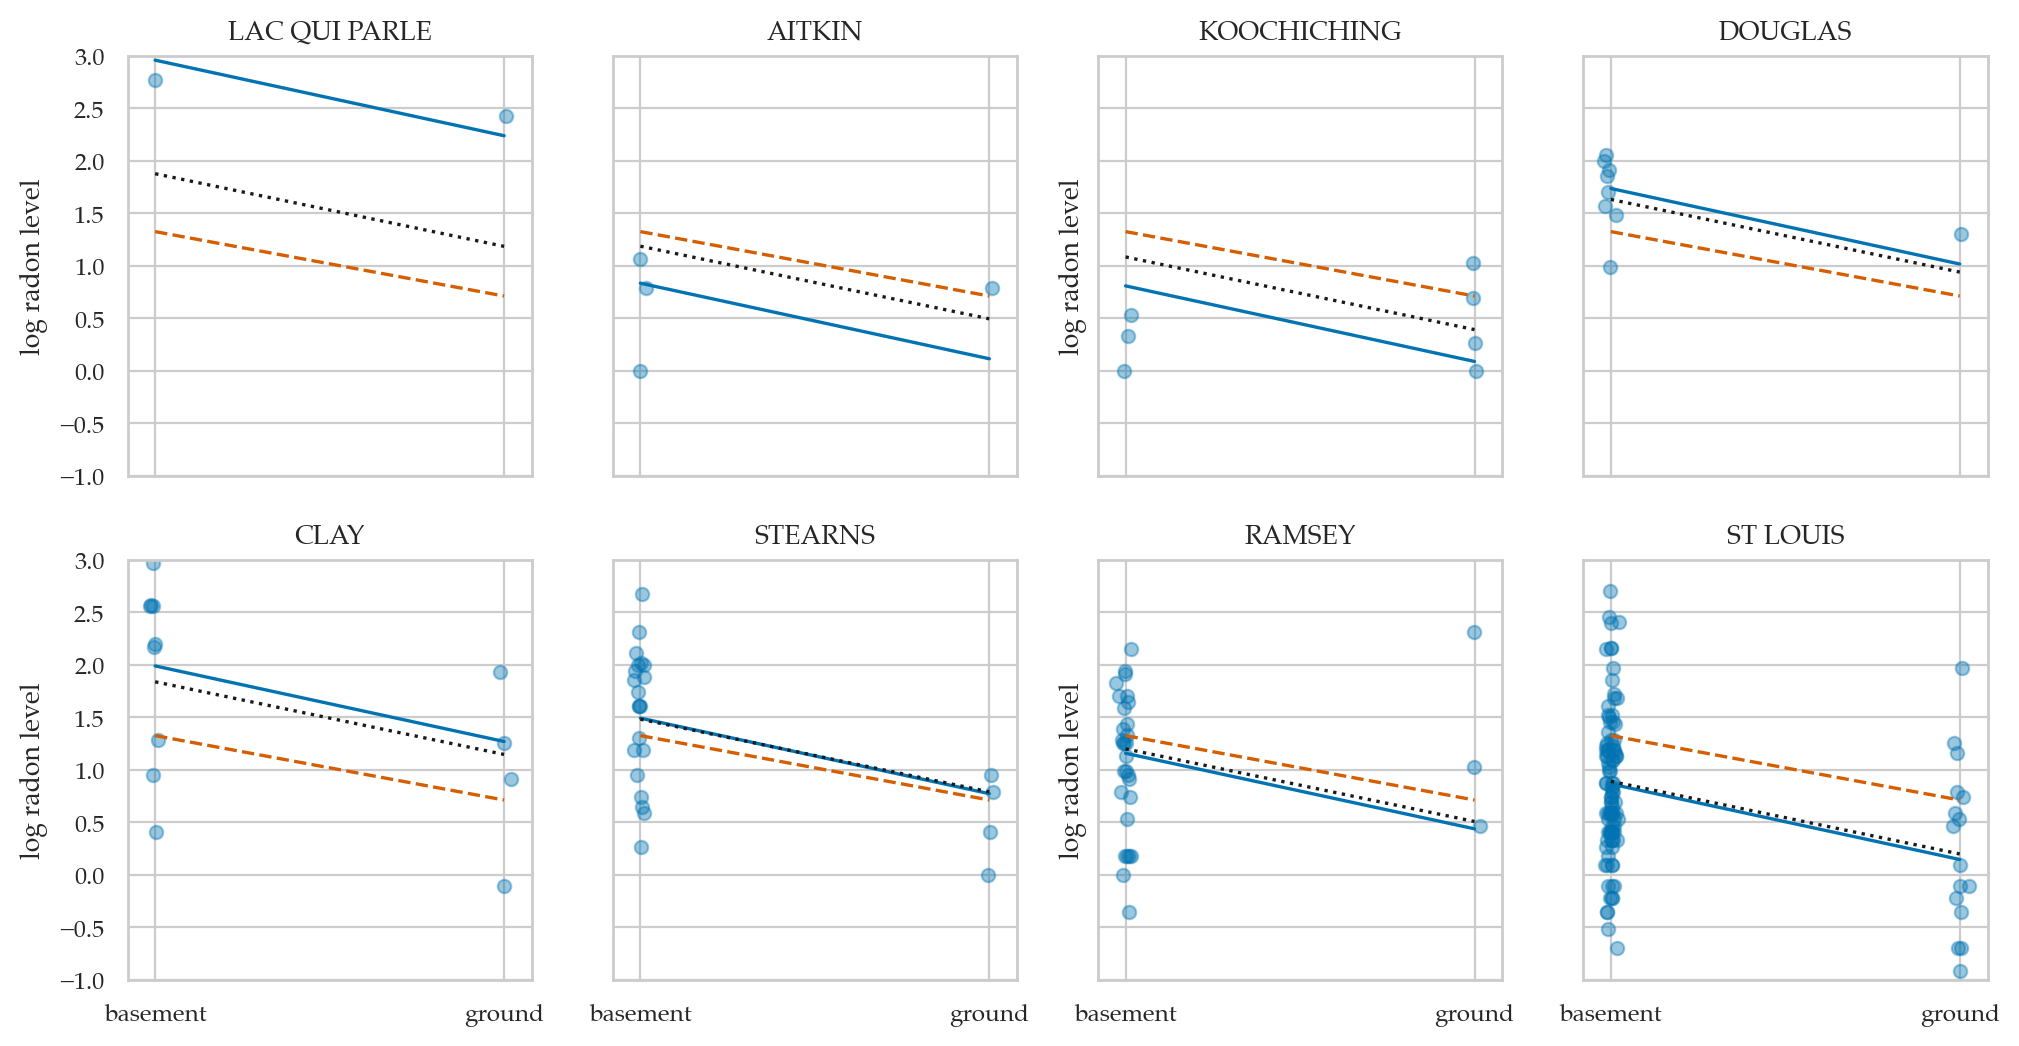

In [25]:
import xarray as xr
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

# completely pooled means
post_mean = idata1.posterior.mean(dim=("chain", "draw"))

# unpooled_means
unpooled_means = idata2.posterior.mean(dim=("chain", "draw"))


fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.flatten()
m = unpooled_means["floor"]

for i, c in enumerate(sample_counties):
    y = radon.log_radon[radon.county == c]
    x = radon.floor[radon.county == c]
    x = x.map({"basement":0, "ground":1})
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["county"].sel(county_dim=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, post_mean["floor"].values * xvals + post_mean["Intercept"], "r--")

    # partial pooling
    post = idata3.posterior.sel(county__factor_dim=c).mean(dim=("chain", "draw"))
    # When using 0 + floor model
    # slope = post.floor.values[1] - post.floor.values[0]
    # theta = post["1|county"].values + post.floor.values[0] + slope * xvals
    # When using 1 + floor model
    slope = post["floor"].values[0]
    theta = post["1|county"].values + post["Intercept"] + slope * xvals
    axes[i].plot(xvals, theta, "k:")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "ground"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

### Conclusions

## Explanations

### Varying intercepts and slopes model


The varying-slope, varying intercept model adds `floor` to the
group-level co-efficients. Now estimates across counties will all have
varying slope.

    log_radon ~ floor + (1 + floor | county_id)

In [26]:
mod4 = bmb.Model("log_radon ~ (1 + floor | county)",
                 data=radon, noncentered=False)
mod4

       Formula: log_radon ~ (1 + floor | county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.1322)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.1322))
            floor|county ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.7237))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

In [27]:
idata4 = mod4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|county_sigma, 1|county, floor|county_sigma, floor|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [28]:
az.autocorr(idata4["posterior"]["sigma"].values.flatten())[0:10]

array([ 1.00000000e+00, -2.34457448e-01,  8.82943822e-02, -1.89437930e-02,
        8.06967338e-03, -5.07836895e-03, -1.75811896e-04,  1.46465872e-03,
       -9.26847402e-03, -8.97504639e-03])

In [29]:
az.summary(idata4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[AITKIN],-0.314,0.271,-0.857,0.172,0.003,0.003,6996.0,2783.0,1.00
1|county[ANOKA],-0.469,0.112,-0.678,-0.260,0.002,0.001,4586.0,3406.0,1.00
1|county[BECKER],-0.055,0.288,-0.611,0.466,0.004,0.004,6806.0,3450.0,1.00
1|county[BELTRAMI],0.032,0.257,-0.436,0.535,0.003,0.004,6501.0,3216.0,1.00
1|county[BENTON],-0.050,0.253,-0.536,0.428,0.003,0.004,7724.0,2857.0,1.00
...,...,...,...,...,...,...,...,...,...
"floor|county[ground, WINONA]",-1.341,0.416,-2.091,-0.513,0.007,0.005,3942.0,2457.0,1.00
"floor|county[ground, WRIGHT]",-0.354,0.533,-1.319,0.674,0.006,0.008,8315.0,3091.0,1.00
"floor|county[ground, YELLOW MEDICINE]",-0.017,0.764,-1.436,1.447,0.008,0.015,8466.0,2813.0,1.00
floor|county_sigma[ground],0.741,0.109,0.542,0.950,0.003,0.002,1065.0,1736.0,1.01


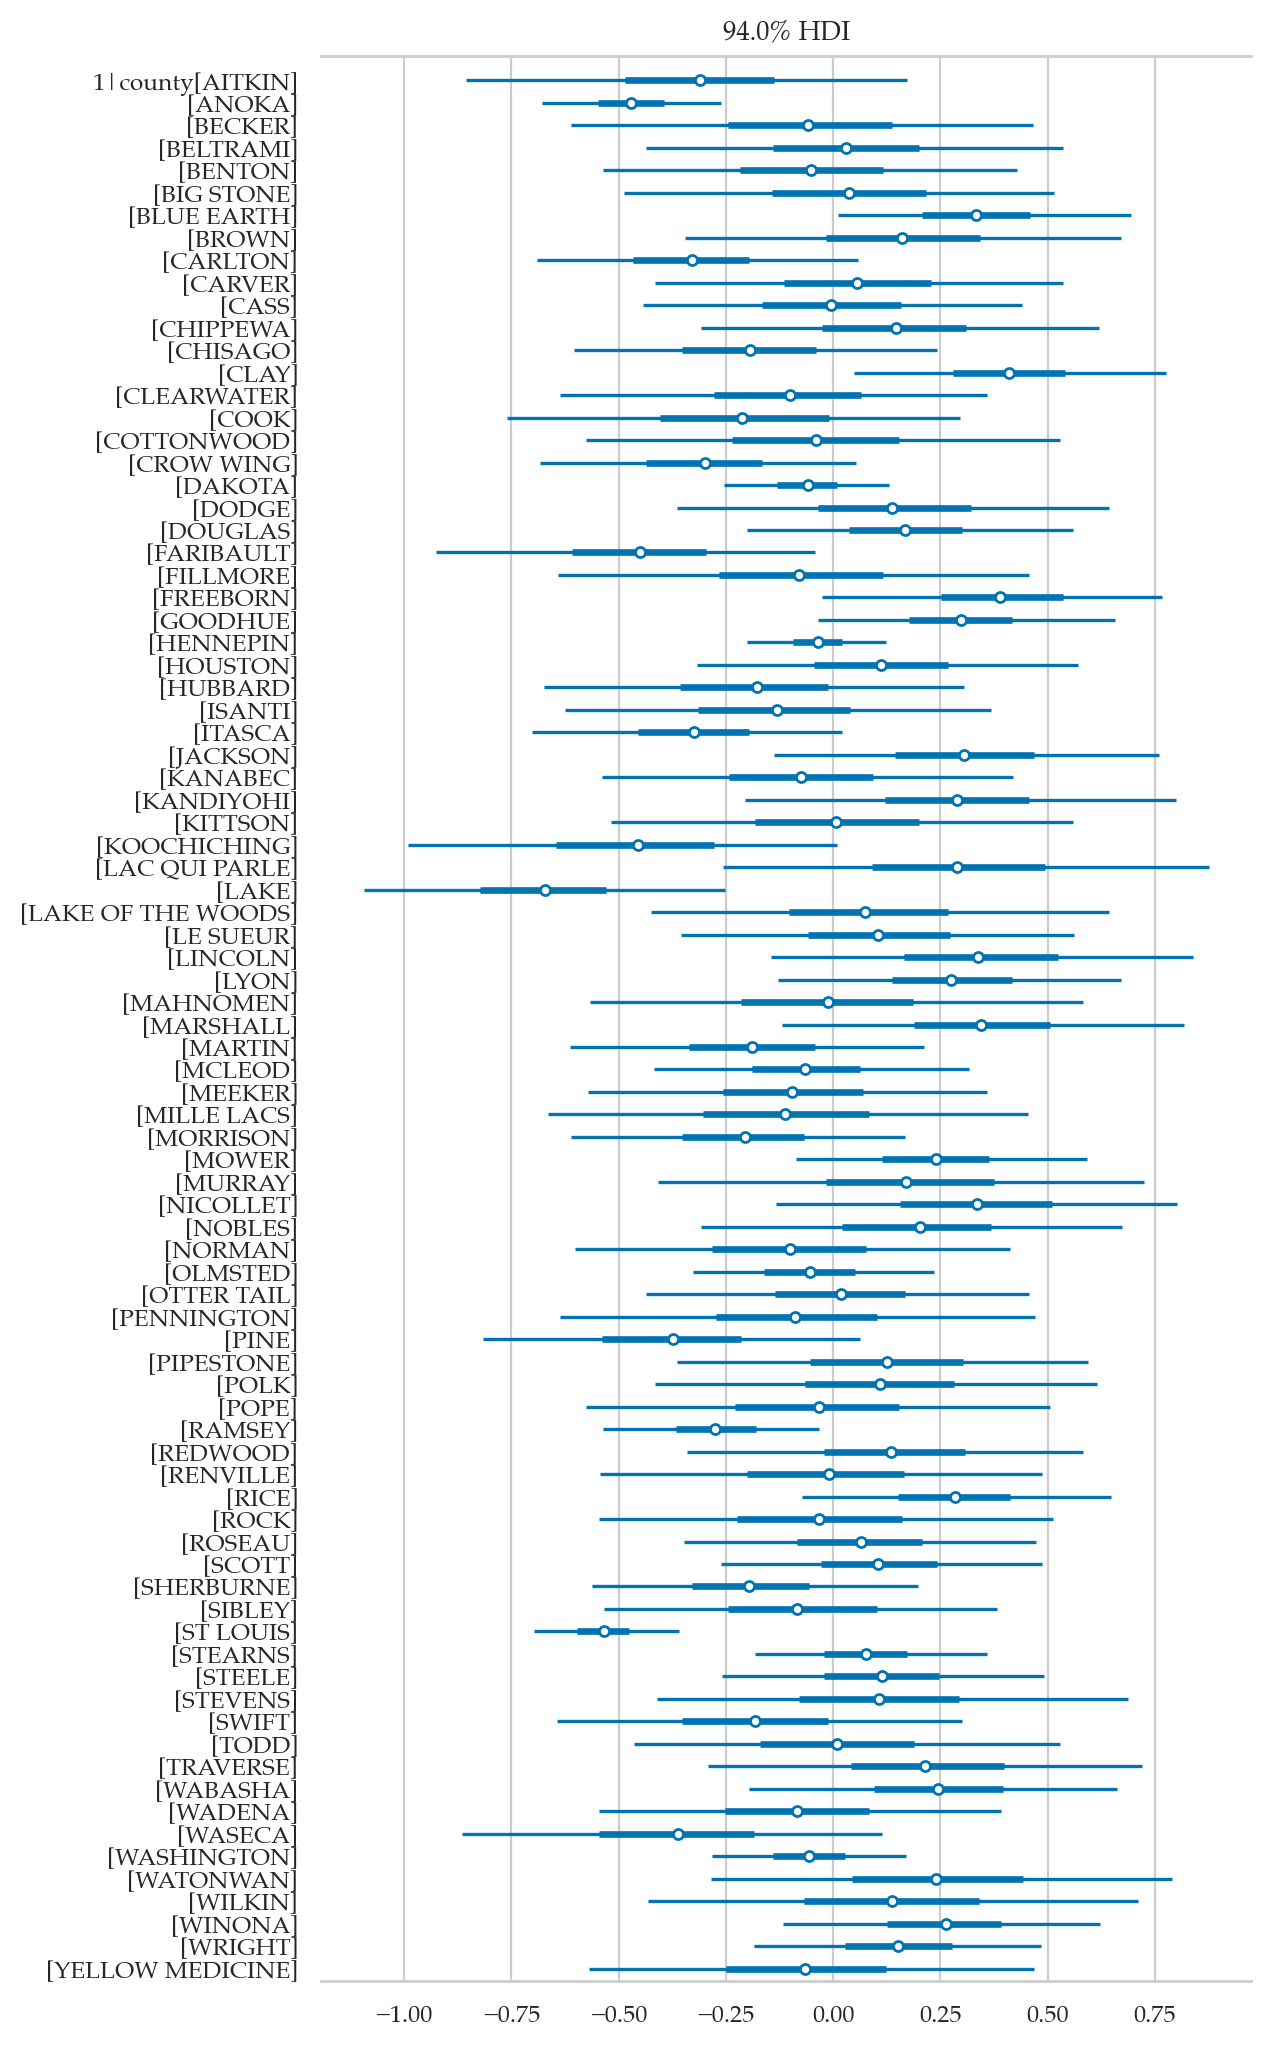

In [30]:
az.plot_forest(idata4, var_names=["1|county"], combined=True);

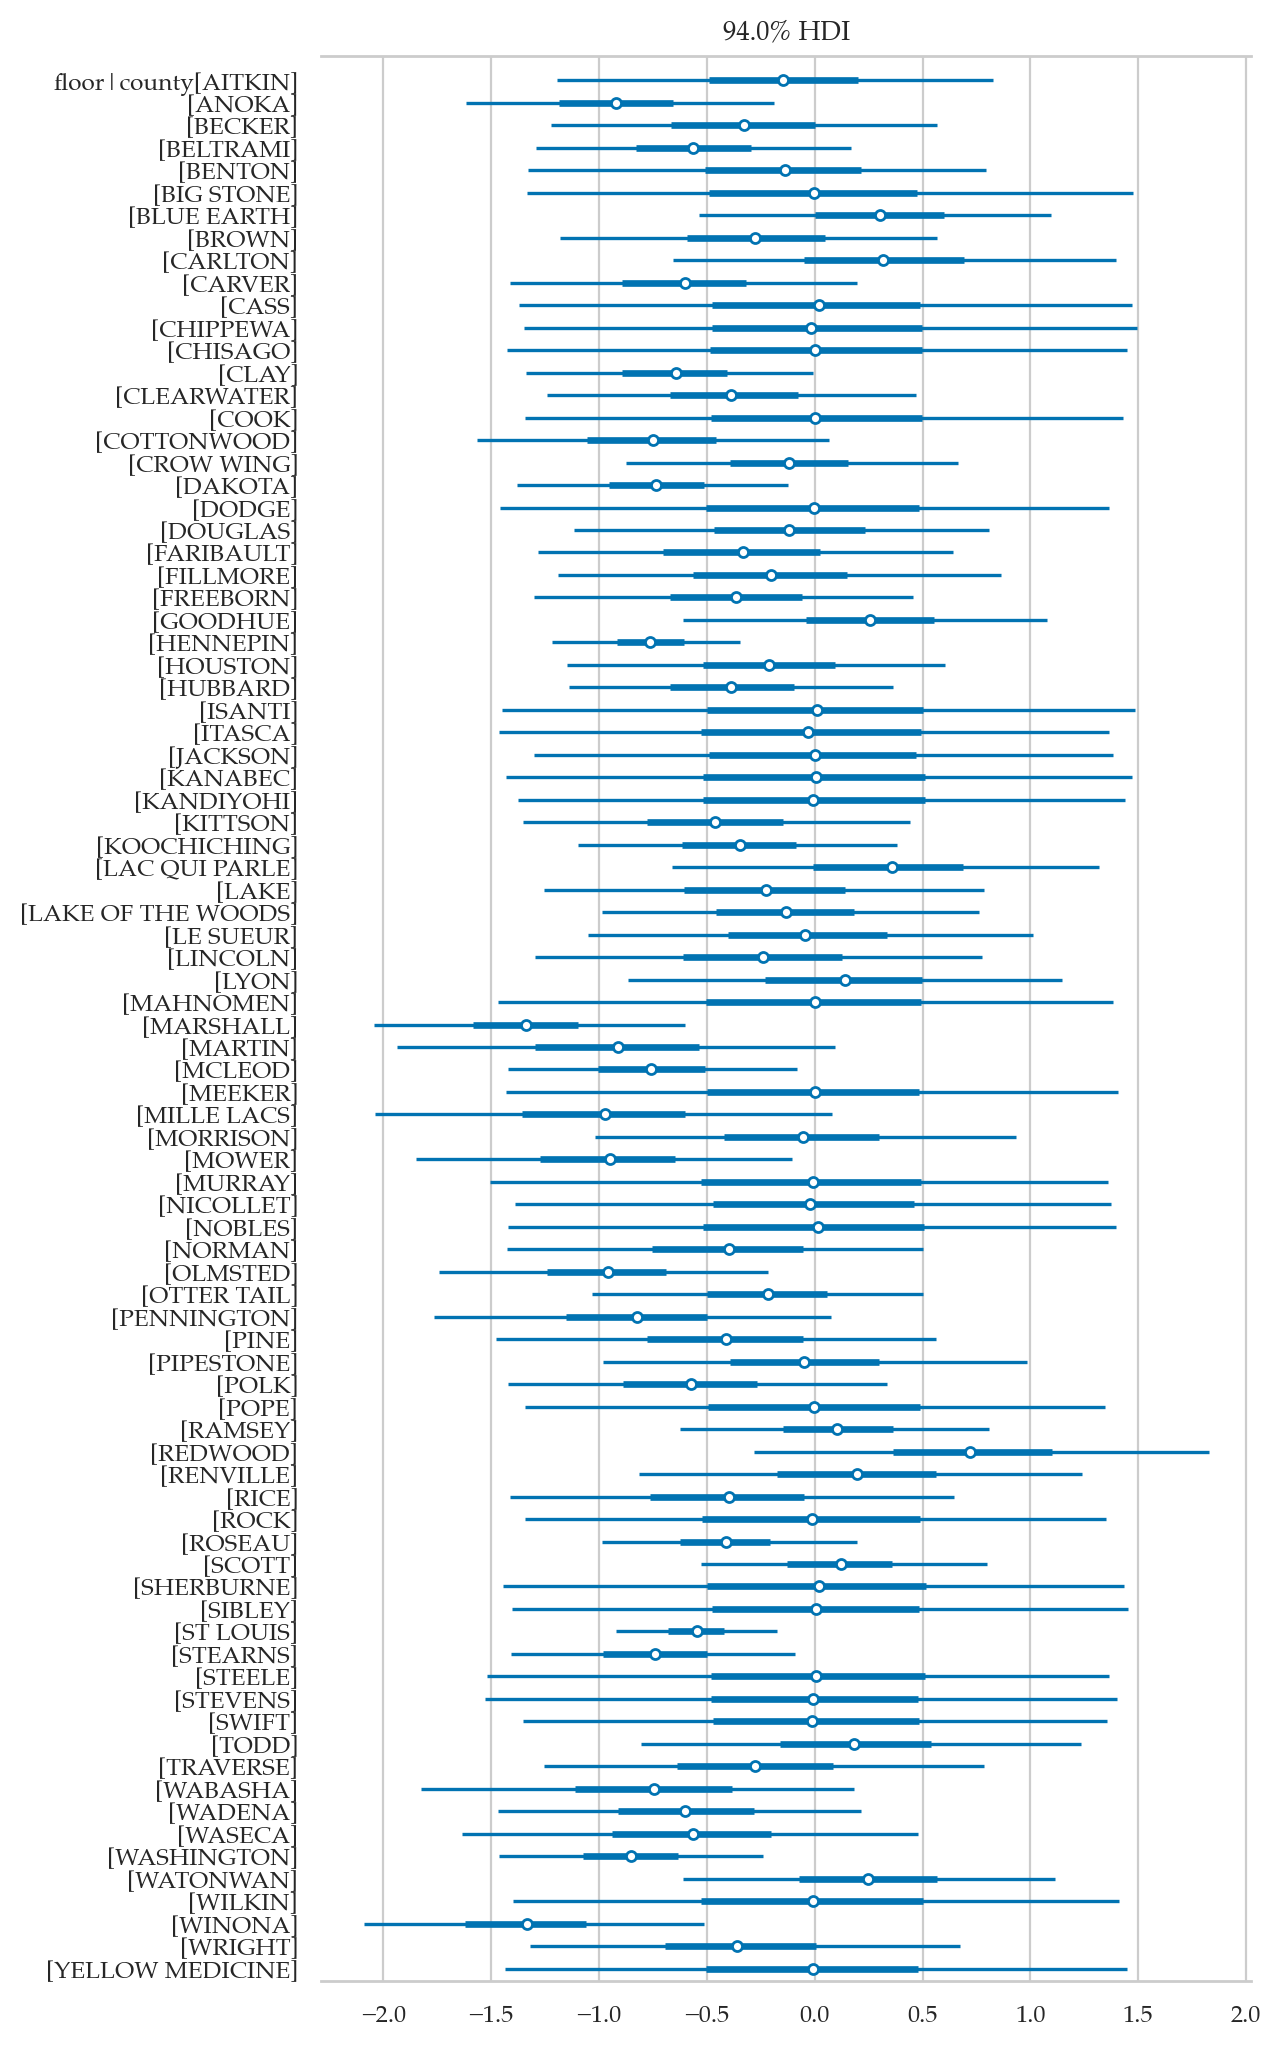

In [31]:
az.plot_forest(idata4, var_names=["floor|county"], combined=True);

### Frequentist approach

We can use `statsmodels` to fit multilevel models too.

#### Varying intercepts model using `statsmodels`

In [32]:
import statsmodels.formula.api as smf
sm1 = smf.mixedlm("log_radon ~ 0 + floor",
                  groups="county",
                  data=radon)
res1 = sm1.fit()
res1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: log_radon 
No. Observations:  919     Method:             REML      
No. Groups:        85      Scale:              0.5709    
Min. group size:   1       Log-Likelihood:     -1085.6526
Max. group size:   116     Converged:          Yes       
Mean group size:   10.8                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
floor[basement] 1.462    0.052 28.164 0.000  1.360  1.563
floor[ground]   0.769    0.074 10.339 0.000  0.623  0.914
county Var      0.108    0.041                           
=========================================================

"""

In [33]:
# slope
res1.params["floor[ground]"] - res1.params["floor[basement]"]

-0.6929937406558043

In [34]:
# sigma-hat
np.sqrt(res1.scale)

0.7555891484188184

In [35]:
# standard deviation of the variability among county-specific Intercepts
county_var = float(res1.summary().tables[1].loc["county Var","Coef."])
assert county_var != res1.params["county Var"]  # BUG??
np.sqrt(county_var)

0.3286335345030997

In [36]:
# compare Intercept for first country in res1 to the Bayesian estimate
res1.random_effects["AITKIN"].values, \
az.summary(idata3, group="posterior",
           var_names=["1|county"],
           coords={"county__factor_dim":"AITKIN"}).iloc[0,0]

(array([-0.27009756]), -0.274)

#### Varying intercepts and slopes model using `statsmodels`

In [37]:
import statsmodels.formula.api as smf
sm2 = smf.mixedlm("log_radon ~ 0 + floor",  # Fixed effects (no intercept and floor as a fixed effect)
                  groups="county",           # Grouping variable for random effects
                  re_formula="1 + floor",    # Random effects: 1 for intercept, floor for slope
                  data=radon)
res2 = sm2.fit()
res2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM      Dependent Variable:      log_radon 
No. Observations:      919          Method:                  REML      
No. Groups:            85           Scale:                   0.5567    
Min. group size:       1            Log-Likelihood:          -1084.1623
Max. group size:       116          Converged:               Yes       
Mean group size:       10.8                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
floor[basement]               1.463    0.054 26.977 0.000  1.356  1.569
floor[ground]                 0.782    0.085  9.208 0.000  0.615  0.948
county Var                    0.122    0.049                           
county x floor[T.ground] Cov -0.040    0.057                           
floor[T.ground] Var           0.118    0.120                           
=======================================================================

"""

In [38]:
# slope
res2.params["floor[ground]"] - res2.params["floor[basement]"]

-0.6810977572101944

In [39]:
# sigma-hat
np.sqrt(res2.scale)

0.7461559982563548

In [40]:
# standard deviation of the variability among county-specific Intercepts
county_var_int = float(res2.summary().tables[1].loc["county Var","Coef."])
np.sqrt(county_var_int)

0.3492849839314596

In [41]:
# standard deviation of the variability among county-specific slopes
county_var_slopes = float(res2.summary().tables[1].loc["floor[T.ground] Var","Coef."])
np.sqrt(county_var_slopes)

0.34351128074635334

In [42]:
# correlation between Intercept and slope group-level coefficients
county_floor_cov = float(res2.summary().tables[1].loc["county x floor[T.ground] Cov","Coef."])
county_floor_cov / (np.sqrt(county_var_int)*np.sqrt(county_var_slopes))

-0.3333796392769246

In [43]:
# TODO: compare Intercept for first country in res1 to the Bayesian estimate
# res2.random_effects["AITKIN"], \
# az.summary(idata1, group="posterior",
#            var_names=["1|county"],
#            coords={"county__factor_dim":"AITKIN"}).iloc[0,0]

## Discussion

## Exercises

### Exercise: mod1u

Same model as Example 1 but also include the predictor `log_uranium`.

In [44]:
import bambi as bmb

covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_uranium": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

mod1u = bmb.Model(formula="log_radon ~ 0 + floor + (1|county) + log_uranium",
                  priors=covariate_priors,
                  data=radon)

mod1u

       Formula: log_radon ~ 0 + floor + (1|county) + log_uranium
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
            log_uranium ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

### Exercise: pigs dataset

https://bambinos.github.io/bambi/notebooks/multi-level_regression.html

In [45]:
import statsmodels.api as sm
dietox = sm.datasets.get_rdataset("dietox", "geepack").data
dietox

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [46]:
pigsmodel = bmb.Model("Weight ~ Time + (Time|Pig)", dietox)
pigsidata = pigsmodel.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [47]:
az.summary(pigsidata, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.743,0.590,14.638,16.869,0.023,0.016,644.0,1449.0,1.01
Time,6.939,0.081,6.790,7.088,0.004,0.003,514.0,923.0,1.00
1|Pig_sigma,4.522,0.450,3.659,5.316,0.013,0.009,1201.0,1853.0,1.00
Time|Pig_sigma,0.659,0.061,0.545,0.772,0.002,0.001,1100.0,1990.0,1.00
sigma,2.460,0.066,2.334,2.582,0.001,0.001,5257.0,2742.0,1.00


### Exercise: educational data

cf. https://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

1.1 Data example
We will be analyzing the Gcsemv dataset (Rasbash et al. 2000) from the mlmRev package in R. 
The data include the General Certificate of Secondary Education (GCSE) exam scores of 1,905 students from 73 schools in England on a science subject. The Gcsemv dataset consists of the following 5 variables:

- school: school identifier
- student: student identifier
- gender: gender of a student (M: Male, F: Female)
- written: total score on written paper
- course: total score on coursework paper


In [48]:
import pyreadr

# Gcsemv_r = pyreadr.read_r('/Users/ivan/Downloads/mlmRev/data/Gcsemv.rda')
# Gcsemv_r["Gcsemv"].dropna().to_csv("../datasets/gcsemv.csv", index=False)

gcsemv = pd.read_csv("../datasets/gcsemv.csv")
gcsemv.head()

,school,student,gender,written,course
0,20920,27,F,39.0,76.8
1,20920,31,F,36.0,87.9
2,20920,42,M,16.0,44.4
3,20920,101,F,49.0,89.8
4,20920,113,M,25.0,17.5


In [49]:
import bambi as bmb
m1 = bmb.Model(formula="course ~ 1 + (1 | school)", data=gcsemv)
m1

       Formula: course ~ 1 + (1 | school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 41.0781)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 41.0781))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [50]:
idata_m1 = m1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|school_sigma, 1|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [51]:
az.summary(idata_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|school[20920],-6.970,5.210,-16.900,2.669,0.067,0.058,6011.0,2939.0,1.0
1|school[22520],-15.654,2.122,-19.806,-11.760,0.046,0.032,2128.0,2404.0,1.0
1|school[22710],6.364,3.738,-0.573,13.293,0.052,0.042,5237.0,2992.0,1.0
1|school[22738],-0.724,4.380,-8.833,7.805,0.057,0.073,5979.0,3025.0,1.0
1|school[22908],-0.792,6.155,-11.484,11.105,0.077,0.107,6382.0,2660.0,1.0
...,...,...,...,...,...,...,...,...,...
1|school[84707],4.070,7.415,-9.964,17.348,0.098,0.115,5741.0,2858.0,1.0
1|school[84772],8.676,3.565,1.784,15.077,0.055,0.041,4143.0,2597.0,1.0
1|school_sigma,8.799,0.931,7.044,10.488,0.033,0.023,854.0,1112.0,1.0
Intercept,73.795,1.132,71.606,75.910,0.037,0.026,943.0,1185.0,1.0


In [52]:
m3 = bmb.Model(formula="course ~ gender + (1 + gender|school)", data=gcsemv)
m3

       Formula: course ~ gender + (1 + gender|school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 53.4663)
            gender ~ Normal(mu: 0.0, sigma: 83.5292)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 53.4663))
            gender|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 83.5292))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [53]:
m3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, gender, 1|school_sigma, 1|school_offset, gender|school_sigma, gender|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Exercise: sleepstudy dataset

- Description: Contains reaction times of subjects under sleep deprivation conditions.
- Source: Featured in the R package lme4.
- Application: Demonstrates linear mixed-effects modeling with random slopes and intercepts.


https://bambinos.github.io/bambi/notebooks/sleepstudy.html

In [54]:
sleepstudy = bmb.load_data("sleepstudy")
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


### Exercise: tadpoles (BONUS)

https://www.youtube.com/watch?v=iwVqiiXYeC4

logistic regression model


## Links

## EXTRA MATERIAL